# Chapter 3: Interpolation and Curve Fitting

![xkcd](https://imgs.xkcd.com/comics/curve_fitting_2x.png)
Source: [xkcd](https://xkcd.com/2048)

## Introduction

Let's consider a set of $n+1$ 2D data points:

$$
\begin{array}{|c|c|c|c|c|}
\hline
x_0 & x_1 & x_2 & \ldots & x_n \\
\hline
y_0 & y_1 & y_2 & \ldots & y_n \\
\hline
\end{array}
$$
For instance, let's generate and plot $n$ random data points:

In [1]:
from numpy import array, arange, zeros
from random import random

def get_random_points(n):
    '''
    Generates n points where x[i] = i and y[i]
    is a random number between 0 and 1.
    '''
    x = arange(n)
    y = zeros(n)
    for i in range(n):
        y[i] = random()
    return x, y

In [2]:
import matplotlib.pyplot as plt
n = 4
x, y = get_random_points(n)
plt.plot(x, y, 'x')
plt.show()

<Figure size 640x480 with 1 Axes>

### Interpolation

Interpolation consists in finding a function $f$ that *passes through* $(x_i, y_i)$: 
$$
y_i = f(x_i) \quad (i=0, 1, \ldots, n)
$$

We will study two types of interpolation functions:
1. Polynomial interpolation
2. Cubic-spline interpolation

Example: polynomial interpolation with [Scipy](https://scipy.org):

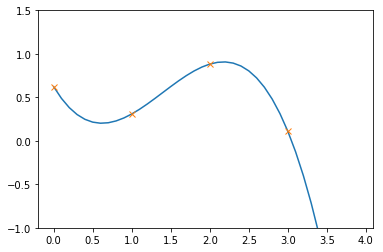

In [3]:
from scipy.interpolate import lagrange # new module: scipy. Works with numpy arrays!
poly = lagrange(x, y)
xfine = arange(0, n, 0.1)
plt.plot(xfine, poly(xfine), "-", x, y, "x")
plt.ylim((-1,1.5))
plt.show()

Example: cubic spline interpolation with Scipy:

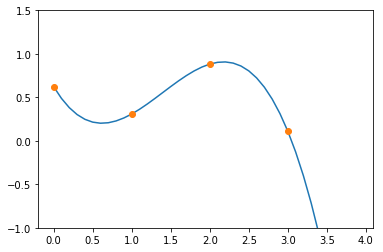

In [4]:
from scipy.interpolate import CubicSpline # that's a class
spline = CubicSpline(x, y)
plt.plot(xfine, spline(xfine), "-", x, y, "o")
plt.ylim((-1, 1.5))
plt.show()

But polynomial and cubic spline interpolation seem to be doing the same thing, so why do we need cubic splines?

*Stay tuned...*

### Curve fitting

Consists in finding a function $f$ that *approximates* $(x_i, y_i)$. In particular, least-square fitting finds $f$ that minimizes:
$$
\sum_{i=0}^n\left(y_i - f(x_i)\right)^2
$$

Example: f is a straight line.

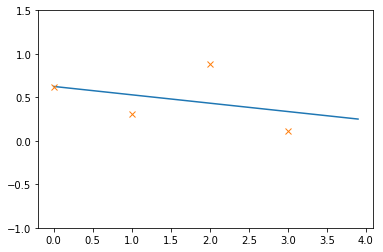

In [5]:
from numpy import polyfit, polyval
line = polyfit(x, y, 1)
plt.plot(xfine, polyval(line, xfine), '-', x, y, 'x')
plt.ylim((-1, 1.5))
plt.show()

Example: f is a degree 2 polynomial

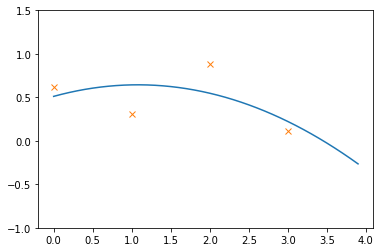

In [6]:
from numpy import polyfit, polyval
poly3 = polyfit(x, y, 2)
plt.plot(xfine, polyval(poly3, xfine), '-', x, y, 'x')
plt.ylim((-1, 1.5))
plt.show()

## Polynomial Interpolation

There is one and only one polynomial $P_n$ of degree $n$ that passes through $n+1$ distinct points. 

This polynomial can be constructed in different ways. Here we will look at:
1. Lagrange method
2. Newton method

### Lagrange method

Lagrange method expresses $P_n$ as follows:
$$
P_n(x) = \sum_{i=0}^n y_i l_i(x)
$$
where $\forall i \in |[0, n]|$:
* $l_i$ is a polynomial of degree n
* $l_i(x_i)$ = 1
* $l_i(x_j)$ = 0, $\quad \forall j \neq i$


The Lagrange polynomials are expressed as follows:

$$
\forall i \in |[0, n]|, \quad l_i(x) = \prod_{j=0 \\ j \neq i}^n \frac{x-x_j}{x_i-x_j}
$$
(Warning: there is a typo in the expression of $l_i$ in the textbook)

For instance, with n=2:

$$
l_0(x) = \frac{(x-x_1)(x-x_2)}{(x_0-x_1)(x_0-x_2)} \quad
l_1(x) = \frac{(x-x_0)(x-x_2)}{(x_1-x_0)(x_1-x_2)} \quad
l_2(x) = \frac{(x-x_0)(x-x_1)}{(x_2-x_0)(x_2-x_1)}
$$



#### Illustration

In [7]:
def lagrange_poly(x_data, i, x):
    '''
    Evaluation of l_i(x) where x_data are the data points
    '''
    assert(i < len(x_data)), i
    p = 1
    for j in range(len(x_data)):
        if j == i:
            continue
        p *= (x-x_data[j])/(x_data[i]-x_data[j])
    return p

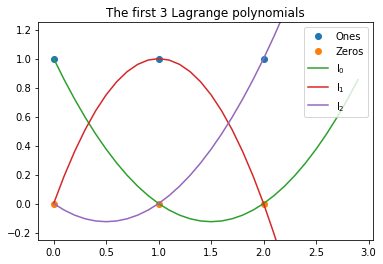

In [8]:
from utils import plot_lagrange_poly  # a module with plotting function. Not critical to the course but feel free to check it out
plot_lagrange_poly(lagrange_poly)

#### Interpolation

In [9]:
def interpol_lagrange(x_data, y_data, x):
    '''
        Returns the value of P_n at x, computed with Lagrange's method
    '''
    s = 0
    for i in range(len(x_data)):
        s += lagrange_poly(x_data, i, x)*y_data[i]
    return s

Illustration

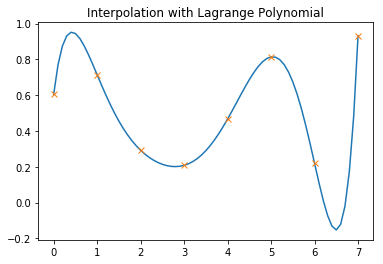

In [10]:
from utils import plot_interpolator

# Points to interpolate
x_data, y_data = get_random_points(8)

plot_interpolator(interpol_lagrange, x_data, y_data, title="Interpolation with Lagrange Polynomial")

### Interpolation Error

It can be shown that:

$$
\forall x \in \mathbb{R}, \quad \exists \xi \in [x_0, x_n], \quad f(x) - P_n(x) = \frac{(x-x_0)(x-x_1)\ldots(x-x_n)}{(n+1)!}f^{(n+1)}(\xi)
$$

This can be used to find an upper bound of the interpolation error, as shown in the example below.

#### Example

(from E. Doedel's lecture notes)
$$
n = 2, \quad f(x) = e^x, \quad x_0=0, \quad x_1=1, \quad x_2=2
$$

$f^{(n+1)}(x)=f^{(3)}(x)=e^x$.

Let's estimate the error for $x=1.5$:

$$
\exists \xi \in [0, 2], \quad f(x) - P_n(x) = \frac{1.5 \times 0.5 \times -0.5}{3 \times 2}e^{\xi}
$$

$$
\Rightarrow f(x) - P(x) \leq \frac{3}{48}e^2 \approx 0.4618
$$

The actual error is:

In [11]:
from math import exp
x = 1.5
#interpol_lagrange([0, 1, 2], [exp(0), exp(1), exp(2)], 1.5)
abs(exp(x) - interpol_lagrange([0, 1, 2],
                               [exp(0), exp(1), exp(2)],
                               x))

0.20291833810521265

### Newton method

The Newton method provides a better algorithm for polynomial interpolation.

Here, $P_n$ is written as follows:

$$
P_n(x) = a_0 + (x-x_0)a_1 + (x-x_0)(x-x_1)a_2 + \ldots + (x-x_0)(x-x_1)\ldots(x-x_{n-1})a_n
$$

which can be transformed to:

$$
P_n(x) = a_0 + (x-x_0)\left[ a_1 + (x-x_1)\left[a_2 + (x-x_2)\left[a_3 + ... \left[a_{n-1} + (x-x_{n-1})a_n \right] \right] \right]\right]
$$

This can be evaluated through the following recurrence relation: 
$$
P_0(x) = a_n \quad \mathrm{and} \quad \forall k \in |[1, n]|, \quad P_k(x) = a_{n-k} + (x-x_{n-k})P_{k-1}(x)
$$

*Once the $a_i$s are known*, the polynomial can be computed as follows:

In [12]:
def eval_poly_newton(a, x_data, x):
    n = len(x_data) - 1
    p = a[-1] # last element in a
    for i in range(1, n+1):
        p = a[n-i] + (x-x_data[n-i])*p
    return p

The coefficients $a_i$ are determined by forcing $P_n(x_i)=y_i$ for every data point:

$$
a_0 = y_0\\
a_1 = \frac{y_1-a_0}{x_1-x_0} = \frac{y_1 - y_0}{x_1 - x_0} \\
a_2 = \frac{y_2 - a_0 - (x_2-x_0)a_1}{(x_2-x_0)(x_2-x_1)} = \frac{\frac{y_2 - y_0}{x_2-x_0} - \frac{y_1 - y_0}{x_1 - x_0} }{x_2-x_1}\\
\ldots
$$

Introducing the *divided differences*:
$$
\nabla y_i = \frac{y_i-y_0}{x_i-x_0} \quad i=1, 2, \ldots, n\\
\nabla^2 y_i = \frac{\nabla y_i-\nabla y_1}{x_i-x_1} \quad i=2, 3, \ldots, n\\
\nabla^3 y_i = \frac{\nabla^2 y_i-\nabla^2 y_2}{x_i-x_2} \quad i=3, 4,  \ldots, n\\
\ldots\\
\nabla^n y_n = \frac{\nabla^{n-1} y_n-\nabla^{n-1} y_{n-1}}{x_n-x_{n-1}} 
$$

we have:
$$
a_0 = y_0, \quad a_1 = \nabla y_1, \quad a_2 = \nabla^2y_2 \quad \ldots \quad a_n=\nabla^n y_n
$$

It is convenient to work with the table below:

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
x_0 & y_0 & & & & \\
\hline
\color{red}{x_1} & y_1 & \color{red}{\nabla y_1} & & & \\
\hline
x_2 & y_2 & \nabla y_2 & \nabla^2 y_2 & & \\
\hline
x_3 & y_3 & \nabla y_3 & \nabla^2 y_3 & \nabla^3 y_3 & \\
\hline
\color{red}{x_4} & y_4 & \color{red}{\nabla y_4} & \color{red}{\nabla^2 y_4} & \nabla^3 y_4 & \nabla^4 y_4\\
\hline
\end{array}
$$
and to fill it in *columns* (the elements in red are used to compute $\nabla^2 y_4$).

In [13]:
def newton_coeffs(x_data, y_data):
    '''
    Returns the coefficients of the Newton polynomial
    '''
    a = y_data.copy()
    m = x_data.size
    assert(m == y_data.size)
    for k in range(1, m): # go through columns of the table
        for i in range(k, m): # go through the lines below the diagonal
            a[i] = (a[i]-a[k-1])/(x_data[i]-x_data[k-1])
            # print(i, k, a[i])
        # now a contains column k of the table
    return a
    

In the program above, a is initialized with y. After 1 iteration (now k=2), it contains the following:

$$
\begin{array}{c}
y_0 \\
\nabla y_1 \\
\nabla y_2 \\
\nabla y_3 \\
\nabla y_4
\end{array}
$$
so a[k-1]=a[1] contains $\nabla y_1$.

Example (using the same points as before):

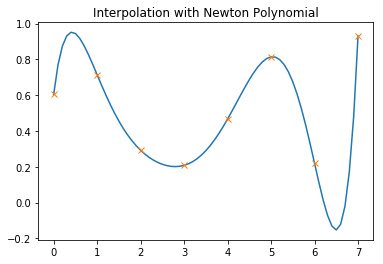

In [14]:
a = newton_coeffs(x_data, y_data)
def newton_poly(x_data, y_data, x):
    return eval_poly_newton(a, x_data, x)

plot_interpolator(newton_poly, x_data, y_data, title="Interpolation with Newton Polynomial")


We get the same result as for Lagrange interpolation (why?)

### Limitations of Polynomial interpolation

When the number of data points increases:
* Polynomials tend to oscillate between points, increasing the error between data points.
* Extrapolation is very dangerous, as high-order polynomials vary rapidly.

Illustration:

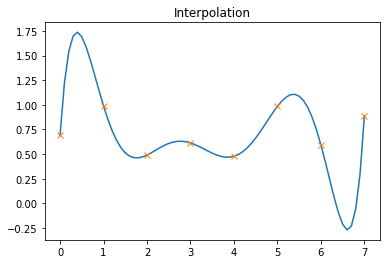

In [15]:
import matplotlib.pyplot as plt
x_data, y_data = get_random_points(8)
plot_interpolator(interpol_lagrange, x_data, y_data)

That's why we need cubic splines!

## Interpolation with Natural Cubic Splines

Cubic Spline address the overfiting issue of high-order Polynomials when there are many data points. 


A cubic spline $f$ is a function of class $C^2$ defined *piecewise*, on $[x_i, x_{i+1}]$:

$$
f(x) = \begin{cases}
f_0(x), \quad \forall x \in [x_0, x_1]\\
f_1(x), \quad \forall x \in [x_1, x_2]\\
\ldots \\
f_{n-1}(x), \quad \forall x \in [x_{n-1}, x_n]
\end{cases}
$$
where $f_i$ is a **polynomial of degree 3**.

### Illustration

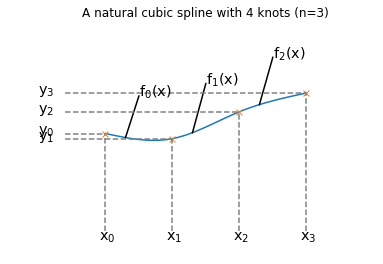

In [16]:
from utils import plot_spline

# Generate n random ponts
n = 4
x, y = get_random_points(n)
plot_spline(x, y)

*Mechanical interpretaion*: a cubic spline models an elastic beam bended by pins located at data points a.k.a *knots*.

### Characterization

To determine the $f_i$, we need to solve a system with 4n unknowns (why?).

Cubic splines respect the following conditions:
0. **Interpolation**: $\quad f(x_{i})=y_i \quad (0 \leq i \leq n)$
1. **Continuity of f**: $\quad f_i(x_{i+1})=f_{i+1}(x_{i+1}), \quad (1 \leq i \leq n-1)$
2. **Continuity of f'** $\quad f'_i(x_{i+1})=f'_{i+1}(x_{i+1}), \quad (1 \leq i \leq n-1)$
3. **Continuity of f''** $\quad f''_i(x_{i+1})=f''_{i+1}(x_{i+1}), \quad (1 \leq i \leq n-1)$

... which makes 4n-2 equations.

The remaining 2 equations will be provided by *boundary conditions*.

A *natural spline* is such that:
$$
f''(x_0) = f''(x_n) = 0
$$

### Resolution

(adapted from http://www.lce.hut.fi/teaching/S-114.1100/lect_6.pdf)

We define $z_i=f''(x_i)$. The boundary conditions give $z_0=z_n=0$.

On each interval, f'' is a linear polynomial and at the endpoints, $f''(x_i)=z_i$ (*continuity of f''*). Thus:
$$
f_i''(x)=\frac{z_{i+1}}{h_i}(x-x_i)+\frac{z_i}{h_i}(x_{i+1}-x)
$$
with $h_i=x_{i+1}-x_i \quad$ (0 $\leq$ i $\leq$ n-1).

Integrating this twice gives:
$$
f_i(x) = \frac{z_{i+1}}{6h_i}(x-x_i)^3+\frac{z_i}{6h_i}(x_{i+1}-x)^3 + c_ix + d_i
$$
where $c_i$ and $d_i$ are integration constants.

We actually adjust the integration constants such that:
$$
f_i(x) = \frac{z_{i+1}}{6h_i}(x-x_i)^3+\frac{z_i}{6h_i}(x_{i+1}-x)^3 + C_i(x-x_i) + D_i(x_{i+1}-x)
$$
where $C_i$ and $D_i$ are constants.


To determine $C_i$ and $D_i$, we impose the *interpolation conditions*: $f(x_i)=y_i$ and $f(x_{i+1})=y_{i+1}$. We obtain:
$$
f_i(x) = \frac{z_{i+1}}{6h_i}(x-x_i)^3+\frac{z_i}{6h_i}(x_{i+1}-x)^3 + \left(\frac{y_{i+1}}{h_i}-\frac{h_i}{6}z_{i+1}\right)(x-x_i) + \left(\frac{y_i}{h_i}-\frac{h_i}{6}z_i\right)(x_{i+1}-x) \quad \textbf{(0)}
$$

We now determine $z_i$ using the remaining equations, the *continuity of f'*. At the interior knots $x_i$ for (1$\leq$i$\leq$n-1), we must have $f'_{i-1}(x_i)=f'_i(x_i)$.

We have:
$$
f_i'(x) = \frac{z_{i+1}}{2h_i}(x-x_i)^2 - \frac{z_i}{2h_i}(x_{i+1}-x)^2 + \frac{y_{i+1}}{h_i}-\frac{h_i}{6}z_{i+1}-\frac{y_i}{h_1}+\frac{h_i}{6}z_i
$$

This gives:
$$
f_i'(x_i) = -\frac{h_i}{6}z_{i+1}-\frac{h_i}{3}z_i+b_i \quad \textbf{(1)}
$$
where
$$
b_i = \frac{1}{h_i}(y_{i+1}-y_i)
$$

Similarly:
$$
f_{i-1}'(x_{i}) = -\frac{h_{i-1}}{6}z_{i-1}-\frac{h_{i-1}}{3}z_i+b_{i-1} \quad \textbf{(2)}
$$

By identification of $\textbf{(1)}$ and $\textbf{(2)}$, we get:

$$
h_{i-1}z_{i-1}+2(h_{i-1}+h_i)z_i+h_iz_{i+1}=6(b_i-b_{i-1})
$$
for 1$\leq$i$\leq$n-1

By letting
$$
u_i = 2(h_{i-1}+h_i)\\
v_i = 6(b_i-b_{i-1})
$$
we obtain a tridiagonal system of n-1 equations:
$$
\begin{bmatrix}
u_1 & h_1 & \\
h_1 & u_2 & h_2 & \\
\ldots\\
&& h_{n-3} & u_{n-2} & h_{n-2} \\
&&& h_{n-2} & u_{n-1}
\end{bmatrix}
\begin{bmatrix}
z_1\\
z_2\\
\ldots\\
z_{n-2} \\
z_{n-1}
\end{bmatrix}
=\begin{bmatrix}
v_1 \\
v_2 \\
\ldots \\
v_{n-2} \\
v_{n-1}
\end{bmatrix} \quad \textbf{(3)}
$$
... and we know how to solve this in O(n) from Chapter 2!



### Algorithm steps
1. Compute $h_i$, $b_i$, $u_i$, $v_i$
2. Solve $\textbf{(3)}$ to compute $z_i$
3. Use $\textbf{(0)}$ to get $f_i$

In [17]:
# From Chapter 2:
# Tridiagonal system solver

def tridiag_decomp(c, d, e):
    assert(len(c) == len(d) == len(e))
    n = len(c)
    for k in range(1, n):
        lambd = c[k-1]/d[k-1]
        d[k] -= lambd*e[k-1]
        c[k-1] = lambd
        
from numpy import zeros
def tridiag_solve(c, d, e, b): # watch out, input has to be in LU form!
    assert(len(c) == len(d) == len(e) == len(b))
    n = len(c)
    # forward substitution
    for i in range(1, n):
        b[i] = b[i]-c[i-1]*b[i-1] # Here we use b to store y
    # back substitution
    b[n-1] = b[n-1]/d[n-1] # Here we use b to store x
    for i in range (n-2, -1, -1):
        b[i] = (b[i]-e[i]*b[i+1])/d[i]

def tridiag_solver(c, d, e, b): # complete solver for tridiagonal systems
    tridiag_decomp(c, d, e)
    tridiag_solve(c, d, e, b)
        

In [18]:
def curvatures(x, y):
    '''
    Returns the zi
    '''
    assert(len(x)==len(y))
    n = len(x) - 1
    # Initialize arrays
    h = zeros(n)
    b = zeros(n)
    u = zeros(n)
    v = zeros(n)
    # Compute array values
    # Be careful, indexing of u and v is shifted (u[0] and v[0] aren't defined)
    for i in range(n):
        h[i] = x[i+1] - x[i]
        b[i] = (y[i+1] - y[i])/h[i]
        if i == 0 :
            continue
        u[i] = 2*(h[i-1]+h[i])
        v[i] = 6*(b[i]-b[i-1])
    e = h.copy() # copy h in e, since the solver will modify the lower diagnoal (c)
    # Careful with indexing: h0 doesn't show in the system
    tridiag_solver(h[1:n], u[1:n], e[1:n], v[1:n]) # as in Chapter 2!
    z = zeros(n+1)
    z[1:n] = v[1:n]
    return z
    
def eval_natural_cubic_spline(x, y, z, x_eval):
    '''
    Evaluates at x_eval the spline defined by x, y with curvatures z.
    '''
    def find_segment(x, x_eval):
        '''
        Finds i such that x[i] <= x_eval <= x[i+1]
        By dichotomic search
        '''
        i = 0
        j = len(x) - 1 # = n
        assert(x_eval <= x[-1])
        while not (x[i] <= x_eval and x_eval <= x[i+1]):
            k = int((i+j)/2)
            if x_eval > x[k]:
                i = k
            else:
                j = k
        return i
    # End of find_segment, back to spline evaluation
    i = find_segment(x, x_eval)
    hi = x[i+1] - x[i]
    # As in equation (0)
    value = (z[i+1]/(6*hi)*(x_eval-x[i])**3 + z[i]/(6*hi)*(x[i+1]-x_eval)**3 +
             (y[i+1]/hi-hi/6*z[i+1])*(x_eval-x[i]) +
             (y[i]/hi-hi/6*z[i])*(x[i+1]-x_eval))
    return value

def eval_natural_cubic_spline_array(x, y, z, x_evals):
    '''
    Just a helper function to evaluate all the elements in an array.
    x_evals is an array
    '''
    n = x_evals.size
    values = zeros(n)
    for i in range(n):
        values[i] = eval_natural_cubic_spline(x, y, z, x_evals[i])
    return values
        


Let's try!

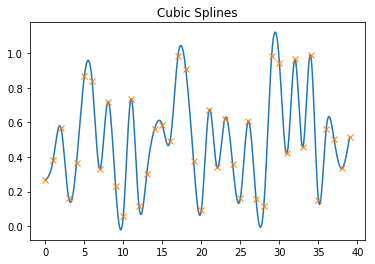

In [19]:
# Generate n random ponts
n = 40
x_data, y_data = get_random_points(n)

z = curvatures(x_data, y_data)
def eval_spline(x_data, y_data, x):
    return eval_natural_cubic_spline(x_data, y_data, z, x)

plot_interpolator(eval_spline, x_data, y_data, title="Cubic Splines")

Comparison with polynomial interpolation:

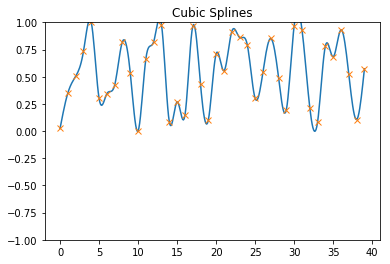

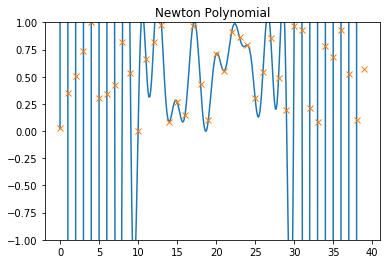

In [20]:
n = 40
x_data, y_data = get_random_points(n)

# Cubic splines
z = curvatures(x_data, y_data)
def eval_spline(x_data, y_data, x):
    return eval_natural_cubic_spline(x_data, y_data, z, x)

plot_interpolator(eval_spline, x_data, y_data, title="Cubic Splines", ylim=1)

# Polynomial
a = newton_coeffs(x_data, y_data)
def newton_poly(x_data, y_data, x):
    return eval_poly_newton(a, x_data, x)

plot_interpolator(newton_poly, x_data, y_data, title="Newton Polynomial", ylim=1)


## Least-square fit

### Overview

Experimental data points are often hampered by *random noise* coming from measurement errors.

Interpolating experimental data points overfits the noise as the interpolant has to pass by every data pont. 

Instead, curve fitting aims at finding a good "average" curve that fits the data points.

The curve is defined by a function $f$ that will be fitted to the n+1 data points $(x_i, y_i) \quad (0 \leq i \leq n)$:
$$
f(x) = f(x; a_0, a_1, \ldots, a_m)
$$

$(a_0, \ldots, a_m)$ are the parameters of this function, and $m < n$.

The form of f(x) is determined beforehand: for instance, in *linear regression*, f is a straight line.

#### What is the "best fit"?

If the noise is confined to the y axis, it is common to use a *least-squares fit*, which minimizes the function:
$$
S(a_0, \ldots, a_m) = \sum_{i=0}^n\left[ y_i - f(x_i) \right] ^2
$$

with respect to each $a_j$. The optimal values of the parameters are given by the solutions of:
$$
\frac{\partial S}{\partial a_k}=0, \quad k=0,\ldots,m \quad \textbf{(1)}
$$

$r_i = y_i -f(x_i)$ are called the **residuals**. S is the sum of the squares of the residuals.

Usually, the equations in $\textbf{(1)}$ are non-linear, and therefore difficult to solve. 

If f is a linear combination of $f_i$ functions, 
$$
f(x) = a_0f_0(x) + a_1f_1(x) + \ldots + a_mf_m(x),
$$
for instance if $f$ is a polynomial, then the equations in $\textbf{(1)}$ are linear.

The spread of the data around the fitting curve is estimated by the *standard deviation* defined as:
$$
\sigma = \sqrt{\frac{S}{n-m}}
$$
If n = m, we have *interpolation*, $\sigma$ is undefined.

### Linear regression

When fitting a straight line, the fitting function is:
$$
f(x) = a+bx
$$

Which gives:
$$
S(a, b) = \sum_{i=0}^n \left( y_i - a -bx_i\right)^2
$$

Equation $\textbf{(1)}$ becomes:

$$
\frac{\partial S}{\partial a} = \sum_{i=0}^n -2(y_i-a-bx_i) = 2 \left[ a (n+1) + b \sum_{i=0}^n{x_i} -  \sum_{i=0}^n{y_i}\right] = 0\\
\frac{\partial S}{\partial b} = \sum_{i=0}^n -2x_i(y_i-a-bx_i) = 2 \left( a\sum_{i=0}^n{x_i}+b\sum_{i=0}^nx_i^2-\sum_{i=0}^nx_iy_i\right)=0
$$

Dividing both equations by 2(n+1), we get:
$$
a + \bar x b = \bar y \quad \quad \bar x a + \left( \frac{1}{n+1} \sum_{i=0}^nx_i^2 \right)b = \frac{1}{n+1}\sum_{i=0}^nx_iy_i
$$

where
$$
\bar x = \frac{1}{n+1} \sum_{i=0}^n x_i \quad \quad \bar y = \frac{1}{n+1} \sum_{i=0}^n y_i 
$$

The solution is:

$$
a = \frac{\bar y \sum_{i=0}^n{x_i^2}-\bar x \sum_{i=0}^n x_iy_i}{\sum_{i=0}^nx_i^2 - (n+1)\bar x^2} \quad \quad
b =\frac{\sum_{i=0}^nx_iy_i-\bar x \sum_{i=0}^ny_i}{\sum_{i=0}^nx_i^2-(n+1)\bar x^2}
$$
Warning: there's a typo in the textbook.

To reduce roundoff errors, it is better to compute the parameters from

$$
b = \frac{\sum_{i=0}^n y_i(x_i-\bar x)}{\sum_{i=0}^n x_i(x_i-\bar x)} \quad \quad a = \bar y -\bar x b
$$

Implementation is straightforward:

In [21]:
from numpy import mean, sum
def linear_regression(x_data, y_data):
    '''
    Returns (a, b)
    '''
    xbar = mean(x_data)
    ybar = mean(y_data)
    b = sum(y_data*(x_data-xbar))/sum(x_data*(x_data-xbar))
    a = ybar - xbar*b
    return (a, b)

Let's try it:

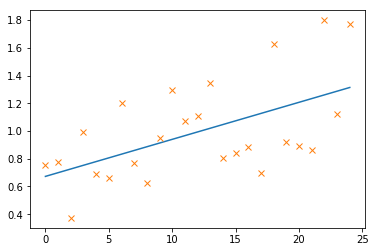

In [22]:
from matplotlib import pyplot as plt

# Data generation
n = 25
x_data, y_data = get_random_points(n)
y_data += x_data/n # Let's give it a positive slope
x_fine = arange(0, n-1+0.1, 0.1)

# Regression
a, b = linear_regression(x_data, y_data)
plt.plot(x_fine, b*x_fine+a, '-', x_data, y_data, 'x')
plt.show()

### Fitting Linear Forms

Here we want to fit the following function:
$$
f(x) = \sum_{j=0}^m a_jf_j(x)
$$

$f_j$ is a predetermined function of $x$ called a *basis function*. We have
$$
S = \sum_{i=0}^n\left[y_i - \sum_{j=0}^ma_jf_j(x_i)\right]^2
$$

The $a_j$ coefficients are the solution of:

$$
\frac{\partial S}{\partial a_k} = -2\left[ \sum_{i=0}^n \left[ y_i - \sum_{j=0}^m a_jf_j(x_i) \right] f_k(x_i) \right] = 0, \quad k=0, 1, \ldots m
$$

which gives:
$$
\sum_{j=0}^m\left[ \sum_{i=0}^n f_j(x_i)f_k(x_i)\right]a_j = \sum_{i=0}^nf_k(x_i)y_i, \quad k=0, 1, \ldots, m
$$

We recognize a system of m linear equations!

$$
\textbf{Aa} = \textbf{b}
$$

where
$$
A_{kj} = \sum_{i=0}^n f_j(x_i)f_k(x_i)
\quad \quad
b_k = \sum_{i=0}^nf_k(x_i)y_i
$$

From Chapter 2, we know how to solve that! Note: the system is symmetrical, $A_{kj}$ = $A_{jk}$.

### Polynomial Fit

A polynomial is a particular case of linear form where
$$
f_j(x) = x^j \quad (j = 0, 1, \ldots, m)
$$

so that $\textbf{A}$ and $\textbf{b}$ become:

$$
A_{kj} = \sum_{i=0}^n x_i^{j+k} \quad \quad b_k = \sum_{i=0}^n x_i^ky_i
$$

Implementation:

In [23]:
from numpy import array, zeros
def polynomial_fit(x_data, y_data, m):
    '''
    Returns the ai
    '''
    # x_power[i] will contain sum_i x_i^k, k = 0, 2m
    m += 1
    x_powers = zeros(2*m)
    b = zeros(m)
    for i in range(2*m):
        x_powers[i] = sum(x_data**i)
        if i < m:
            b[i] = sum(y_data*x_data**i)
    a = zeros((m, m))
    for k in range(m):
        for j in range(m):
            a[k, j] = x_powers[j+k]
    from numpy.linalg import solve # using linalg for brevity here, but we could use the solvers developed in Chap 2.
    return solve(a, b)

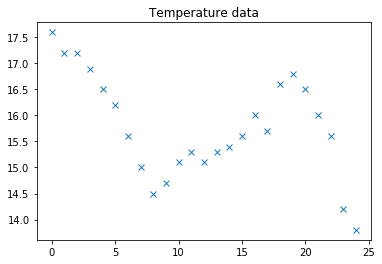

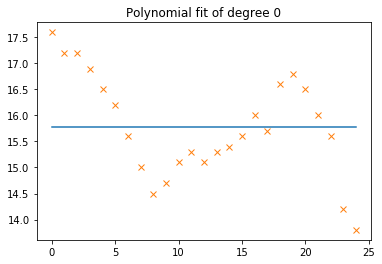

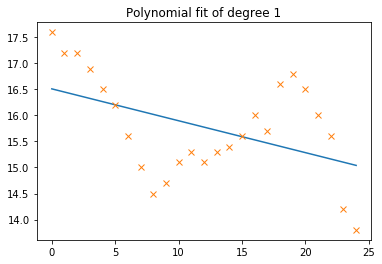

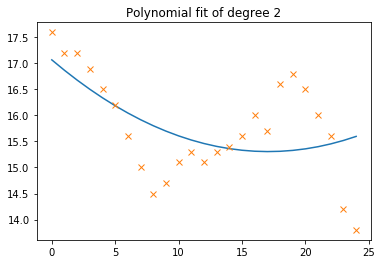

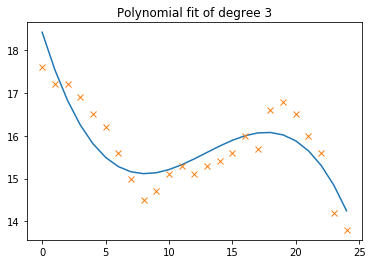

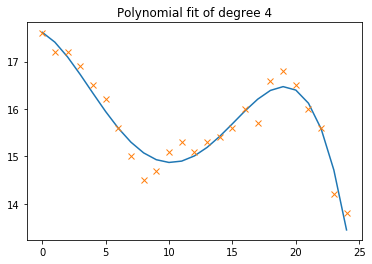

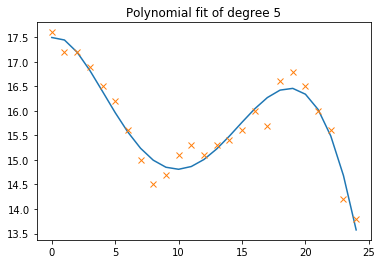

In [24]:
from matplotlib import pyplot as plt
from numpy import arange
temperatures = array([17.6, 17.2, 17.2, 16.9, 16.5, 16.2, 15.6, 15.0, 14.5, 14.7, 15.1, 15.3, 15.1, 15.3, 15.4, 15.6, 16.0, 15.7, 16.6, 16.8, 16.5, 16.0, 15.6, 14.2, 13.8])
hours = arange(25)
plt.plot(hours, temperatures, 'x')
plt.title("Temperature data")
plt.show()

hours_fine = arange(0, 25.1, 0.01)
for i in range(6):
    plt.title("Polynomial fit of degree {}".format(i))
    a = polynomial_fit(hours, temperatures, i)
    temperatures_interp = zeros(temperatures.size)
    for j in range(temperatures.size):
        for k in range(a.size):
            temperatures_interp[j] += a[k]*hours[j]**k
    plt.plot(hours, temperatures_interp, '-', hours, temperatures, 'x')
    plt.show()